<a href="https://colab.research.google.com/github/ninavergara605/capstone/blob/main/modeling_scripts/dummy_and_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports 

#### Outside Modeling Functions and Warning Suppression

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#### Google collab setup

In [1]:
from google.colab import drive, files

drive.mount("/content/gdrive", force_remount=True)
files.upload() #Upload the modeling_functions script to the virtual environment

#Import user defined modeling functions
from modeling_functions import grid_search_cv
from modeling_functions import evaluate_model

Mounted at /content/gdrive


Saving modeling_functions.py to modeling_functions.py


#### Training Data Imports

In [4]:
X_train = pd.read_csv('/content/gdrive/MyDrive/capstone/data/X_train.csv')
y_train = pd.read_csv('/content/gdrive/MyDrive/capstone/data/y_train.csv').values.ravel()

### Dummy Accuracy: always predicts the majority class

In [7]:
dummy_accuracy = len(y_train[y_train == 0])/ len(y_train)
dummy_accuracy

0.5011649417529124

## Logistic Regression

### Baseline Model: default parameters 

Average accuracy-- test: 0.8411879167581877, train: 0.8414779211988686
Average f1-- test: 0.8446609737608075, train: 0.8449137103555717
Average roc_auc-- test roc_auc: 0.9107385429173807, train: 0.9108062360917235


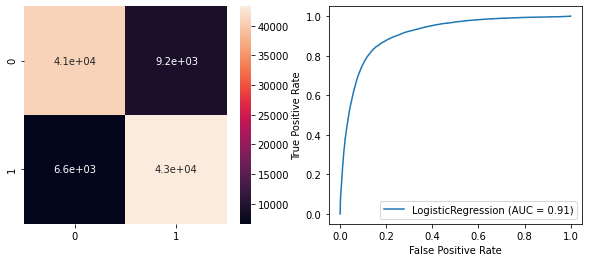

In [8]:
evaluate_model(LogisticRegression(), X_train, y_train)

Overall decent scores. Looks like the baseline model is misclassifing non-cheaters as cheaters.

### Determining the Optimal Penalty Solver

Grid search options:
*   penalty solver algorithms
*   intercept inclusion
*   intercept scaling
*   penalty inclusion
*   regularization strength (inverse)

#### l2 Penalty Grid Search

Average accuracy-- test: 0.8408479576021198, train: 0.8411979401029948
Average f1-- test: 0.8437735441370544, train: 0.8441090536940878
Average roc_auc-- test roc_auc: 0.9118033130925622, train: 0.9120308470622227


{'C': 1e-05,
 'fit_intercept': True,
 'intercept_scaling': 1e-05,
 'penalty': 'none',
 'solver': 'lbfgs',
 'warm_start': True}

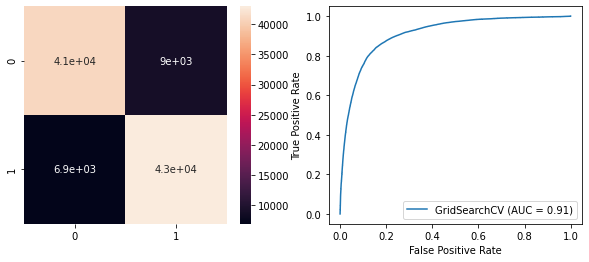

In [9]:
logreg_l2 = LogisticRegression(max_iter=5000, multi_class='ovr')
logreg_l2_param_grid = {
                  'solver':['lbfgs','sag']
                  ,'fit_intercept': [True, False]
                  ,'intercept_scaling': [1e-5,1e-10]
                  ,'penalty':['l2','none']
                  ,'C': [1e-5,1e-10]
                  ,'warm_start': [True, False]
}               
best_params_l2 = grid_search_cv(logreg_l2, logreg_l2_param_grid, X_train, y_train)                  
best_params_l2

Very small decrease in test and train accuracy and f1 scores.

Looks like an extremely small intercept is better than none at all and that l2 penalty existence isn't doing the trick. 



#### l1 Penalty Grid Search

Finding the best parameters for algorithms that utilize l1 penalties. 

*   l1 algorithms
*   intercept inclusion
*   intercept scaling
*   penalty inclusion
*   regularization strength (inverse)

Average accuracy-- test: 0.8408479576021198, train: 0.8407529623518825
Average f1-- test: 0.8439229821854257, train: 0.843810965289431
Average roc_auc-- test roc_auc: 0.9114098602802511, train: 0.9115324578188077


{'C': 1e-05,
 'fit_intercept': True,
 'intercept_scaling': 1e-05,
 'penalty': 'none',
 'solver': 'saga',
 'warm_start': False}

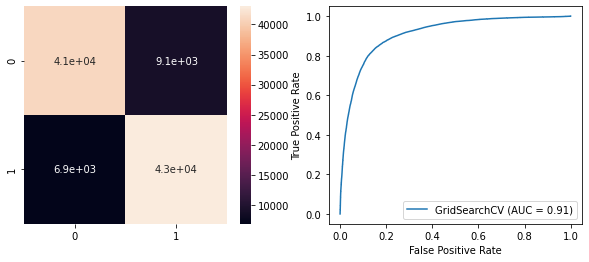

In [10]:
logreg_l1_param_grid = {
                  'solver':['saga', 'liblinear']
                  ,'fit_intercept': [True, False]
                  ,'intercept_scaling': [1e-5,1e-10]
                  ,'penalty':['l1','none']
                  ,'C': [1e-5,1e-10]
                  ,'warm_start': [True, False]
}               
logreg_l1 = LogisticRegression(max_iter=5000, multi_class='ovr')
best_params_l1 = grid_search_cv(logreg_l1, logreg_l1_param_grid, X_train, y_train)                  
best_params_l1

Very small decrease in training scores. Again, it looks like the penalites aren't preferred.

Again, a small intercept and inverse regularization parameter is optimal. These will be added as default parameters for the elasticnet penalty model to save processing time.

#### Elasticnet Penalty Grid Search

Average accuracy-- test: 0.7506824658767062, train: 0.7505474726263687
Average f1-- test: 0.7434480273028653, train: 0.7433138106389616
Average roc_auc-- test roc_auc: 0.823524385485985, train: 0.8235524165443422


{'l1_ratio': 0.05}

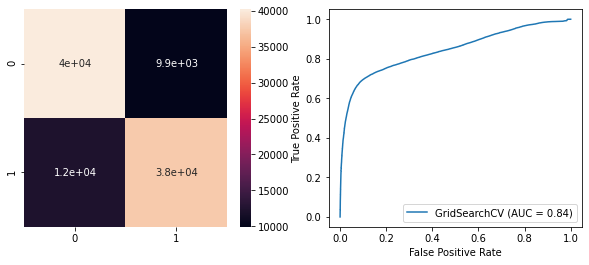

In [11]:
logreg_elasticnet_param_grid = {'l1_ratio': [0.05,0.15,0.25,0.4,0.6]}
logreg_elasticnet = LogisticRegression(max_iter=5000
                              ,multi_class='ovr'
                              ,solver='saga'
                              ,penalty='elasticnet'
                              ,C=1e-5
                              ,warm_start=True
                              ,intercept_scaling=1e-5
                              ,fit_intercept=True)
best_params_elasticnet = grid_search_cv(logreg_elasticnet, logreg_elasticnet_param_grid, X_train, y_train)                  
best_params_elasticnet

The lowest performing model in all accuracy measures. The algorithm preferred a very low l1 ratio for solver penalty.

### Selected parameters

 Although the diffreneces in scoring metrics across all models were small, the parameters that outpreformed all others were:
* C: 1e-05
* fit_intercept: True
* intercept_scaling: 1e-05
* penalty: none
* solver: saga
* warm_start: True

The saga solver seems to be the parameter that increased the model score, since the rest of the parameters were returned as best model parameters for every grid search.